# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 13

**Author 1 (sciper):** Valérie Costa (315855)  
**Author 2 (sciper):** Jennifer Abou-Najm (312656)   
**Author 3 (sciper):** Arthur Wuhrmann (344752)  

**Release date:** 8.03.2023  
**Due date:** 24.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, "data")
print(data_base_path)
data_folder = "lab-01-data"
tar_path = os.path.join(data_base_path, data_folder + ".tar.gz")

if not os.path.exists(tar_path):
    raise Exception("Path to is not valid {}".format(tar_path))

with tarfile.open(tar_path, mode="r:gz") as tar:
    tar.extractall(path=data_base_path)

..\data


---
## Part 1: Segmentation


### 1.0 Intro

In this exercise, you will be given two images. 

* `mucinous_adeno.jpg`: The image depicts a tissue sample from mucinous adenocarcinoma in colorectal cancer. The data is taken from the Cancer Genome Atlas (TCGA) which is an open-source database of different cancer types. Here you can see a tissue taken from a patient and stained using hematoxylin (purple) and eosin (pink) staining. The hematoxylin stains cell nuclei with a purplish blue, and the eosin stains the extracellular matrix and cytoplasm in pink.

* `mucinous_adeno_gt.jpg`: The second image is a coarse annotation of what is regarded as the so-called mucinous area. The mucinous area can be identified as a gray area tainted with purple. The presence of a large amount of mucin is a sign of a defect of normal epithelial cells that start to produce an unreasonable amount of mucin.


### 1.1 Tasks

You will be asked to extract the mucinous area using various approaches:

- [ ] Thresholding
- [ ] Morphology
- [ ] Region growing


### 1.1 Brain image visualization

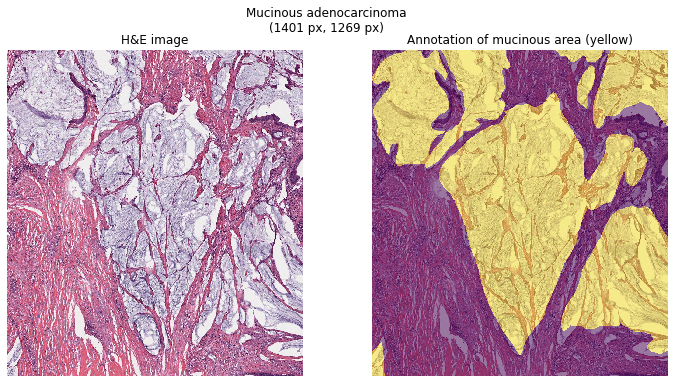

In [2]:
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.rcParams["figure.facecolor"] = "white"

# Load images
path_to_image = os.path.join(data_base_path, data_folder, "mucinous_adeno.jpg")
path_to_gt = os.path.join(data_base_path, data_folder, "mucinous_adeno_gt.jpg")
adeno_img = skimage.io.imread(path_to_image)
adeno_gt = skimage.io.imread(path_to_gt) > 128

# Get size of the image in px
im_h, im_w, im_c = adeno_img.shape

# Display MRI image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot image
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].set_title('H&E image'.format(im_h, im_w))
ax[0].axis('off')

# Plot image with overlay
ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[1].set_title('Annotation of mucinous area (yellow)')
ax[1].axis('off')
plt.suptitle("Mucinous adenocarcinoma\n({} px, {} px)".format(im_h, im_w))
plt.show()


---
### 1.2 Thresholding (4pts)
#### 1.2.1 RGB & Hue (1 pts)

Display the histogram for each channel (R, G, and B) as well as the histogram for the H (hue) channel. Note that you can use [rgb2hsv](https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.rgb2hsv) to convert an RGB image to an HSV image and then extract the hue.

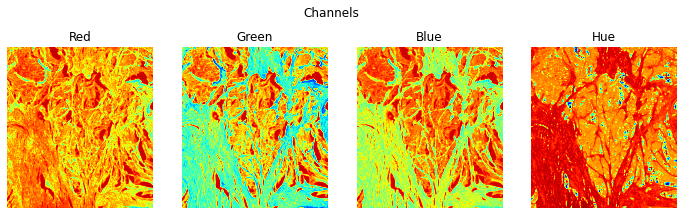

In [3]:
# Displaying the RGB and Hue channels of the studied image
title = ["Red", "Green", "Blue", "Hue"]
fig, ax = plt.subplots(1, 4, figsize=(12, 3.5))
fig.suptitle("Channels")
for i in range(3):
    ax[i].imshow(adeno_img[:, :, i], cmap="jet")
    ax[i].axis("off")
    ax[i].set_title(title[i])
ax[3].imshow(skimage.color.rgb2hsv(adeno_img)[:, :, 0], cmap="jet")
ax[3].axis("off")
ax[3].set_title(title[3])
plt.show()

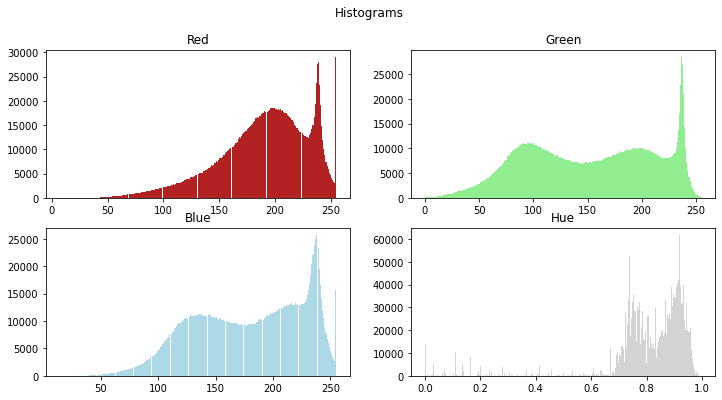

In [4]:
#Displaying the histograms for the RGB and Hue channels of the studied image
colors = ["firebrick", "lightgreen", "lightblue", "lightgray"]
fig = plt.figure(figsize=(12, 6))
fig.suptitle("Histograms")
for i in range(3):
    plt.subplot(2, 2, i + 1)
    plt.hist(adeno_img[:, :, i].ravel(), 256, color=colors[i])
    plt.title(title[i])
    
plt.subplot(2, 2, 4)
plt.hist(skimage.color.rgb2hsv(adeno_img)[:, :, 0].ravel(), 256, color=colors[3])
plt.title(title[3])
plt.show()

#### 1.2.2 Apply Thresholding (2 pts)

For each histogram find the threshold(s) that work the best to isolate the mucinous area. Display the image after thresholding of each channel as well as the error between your prediction ($im$) and the annotations ($gt$) using the formula:

$$error = 1 - \left( \frac{1}{IJ} \sum_{i,j} im_{i,j} == gt_{i, j} \right)$$

Here, I and J are the dimension of the image.

In [5]:
#Defining a function to calculate the error
def error(im,gt):
    tot = np.sum(im==gt)/im.size
    return 1-tot

In [6]:
mask_red = adeno_img[:,:,0]<230
mask_green = adeno_img[:,:,1]>145
mask_blue = adeno_img[:,:,2]>177
mask_hue = skimage.color.rgb2hsv(adeno_img)[:,:,0]<0.84

In [7]:
masks = {"mask_red": mask_red, "mask_green": mask_green, "mask_blue": mask_blue, "mask_hue": mask_hue}

for name, mask in masks.items():
    print("The error for", name, "is", round(error(mask, adeno_gt),5))

The error for mask_red is 0.5121
The error for mask_green is 0.26148
The error for mask_blue is 0.27352
The error for mask_hue is 0.19013


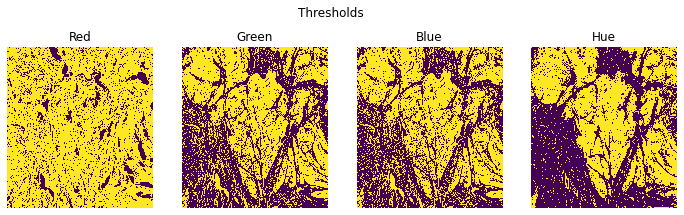

In [8]:
fig, ax = plt.subplots(1,4, figsize=(12, 3.5))
fig.suptitle("Thresholds")

ax[0].imshow(mask_red, interpolation='nearest')
ax[0].set_title('Red'.format(im_h, im_w))
ax[0].axis("off")

ax[1].imshow(mask_green, interpolation='nearest')
ax[1].set_title('Green'.format(im_h, im_w))
ax[1].axis("off")

ax[2].imshow(mask_blue, interpolation='nearest')
ax[2].set_title('Blue'.format(im_h, im_w))
ax[2].axis("off")

ax[3].imshow(mask_hue, interpolation='nearest')
ax[3].set_title('Hue'.format(im_h, im_w))
ax[3].axis("off")

plt.show()

In [9]:
#Best combination of thresholds obtained with the search algorithm
mask_thresholding_combi = np.zeros_like(adeno_gt)
mask_thresholding_combi[mask_blue & mask_red & mask_green & mask_hue]=1

In [10]:
# Error between our prediction ($im$) using thresholding (combination of thresholds) and the annotations ($gt$)
print("Error achieved with a combination of thresholds:", round(error(mask_thresholding_combi,adeno_gt),5))

Error achieved with a combination of thresholds: 0.29682


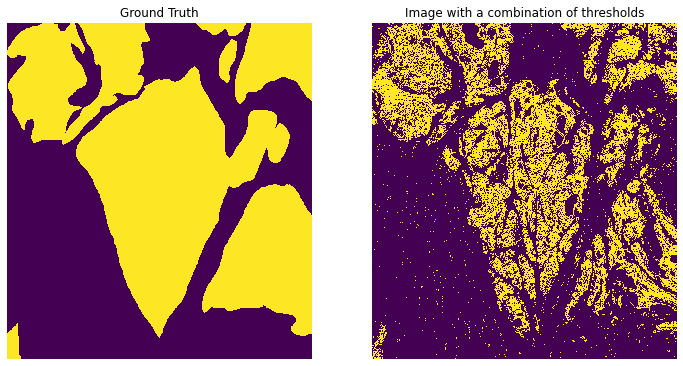

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 10))

ax[0].imshow(adeno_gt,  interpolation='nearest')
ax[0].set_title('Ground Truth')
ax[0].axis('off')

ax[1].imshow(mask_thresholding_combi, interpolation='nearest')
ax[1].set_title('Image with a combination of thresholds')
ax[1].axis('off')

plt.show()

We approached the exercise in two different ways. In the first approach, we selected a threshold independently for each channel based on the histogram and fine-tuned each threshold based on the error. We then evaluated the resulting pictures and error for each threshold. The best error of 0.19 was achieved using a threshold on the hue channel.

In the second approach, we attempted to improve the results by combining the thresholds of the different channels. To find the best combination of thresholds, we implemented a simple search algorithm based on the error. However, this method resulted in a higher error of 0.296, which is not as good as with the the first approach.

As a result, we ultimately chose to implement thresholding only with the hue channel.

#### 1.2.3 Best Thresholding (1 pts)

Based on your previous findings, set the best threshold(s) and create the final mask as the variable `mask_thesholding`

In [12]:
# Replace variable with your own threshold
mask_thresholding = np.zeros_like(adeno_gt)
mask_thresholding[mask_hue]=1

In [13]:
# Error between our prediction ($im$) using thresholding and the annotations ($gt$)
print("The error achieved with thresholding is:", round(error(mask_thresholding,adeno_gt),4))

The error achieved with thresholding is: 0.1901


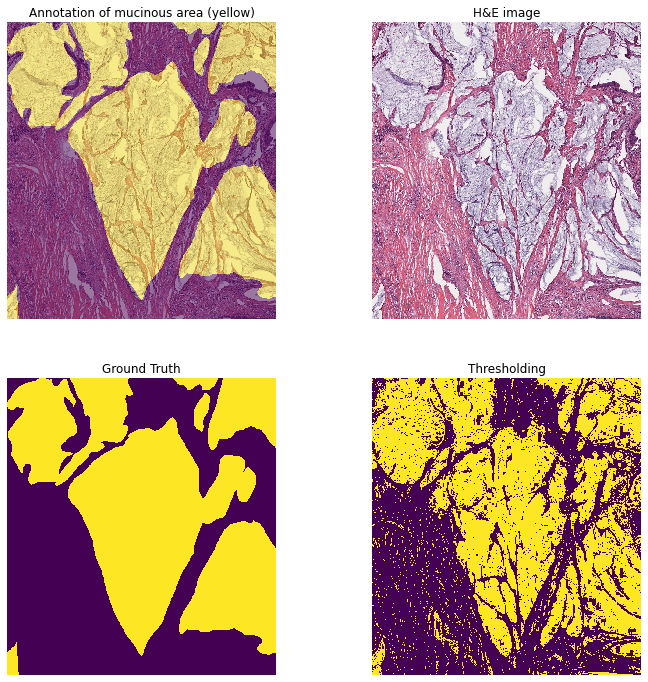

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# Plot image
ax[0][1].imshow(adeno_img, interpolation='nearest')
ax[0][1].set_title('H&E image'.format(im_h, im_w))
ax[0][1].axis('off')

ax[0][0].imshow(adeno_img, interpolation='nearest')
ax[0][0].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[0][0].set_title('Annotation of mucinous area (yellow)')
ax[0][0].axis('off')

ax[1][1].imshow(mask_thresholding, interpolation='nearest')
ax[1][1].set_title('Thresholding')
ax[1][1].axis('off')

ax[1][0].imshow(adeno_gt, interpolation='nearest')
ax[1][0].set_title('Ground Truth')
ax[1][0].axis('off')

plt.show()

---

### 1.3 Morphology (5pts)

To proceed, use the best results of the previous model (namely `mask_thesholding`) as the starting point. In this exercise we will try to clean the mask using morphology.

* A (2pts): Try the following operation [closing](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.closing), [opening](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.opening) with [disk](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.disk) size of: $1, 2, 5, 10$. Comment on the quality of the results.

* B (2pts): Try the following operation [remove_small_holes](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_holes), [remove_small_objects](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_objects) with size of: $10, 50, 100, 500$. Comment on the quality of the results.

* C (1pts): Based on your previous results, can you find a combination of the functions that improve your results? Plot the best result along with the error rate. Save the mask as the variable `mask_morph`

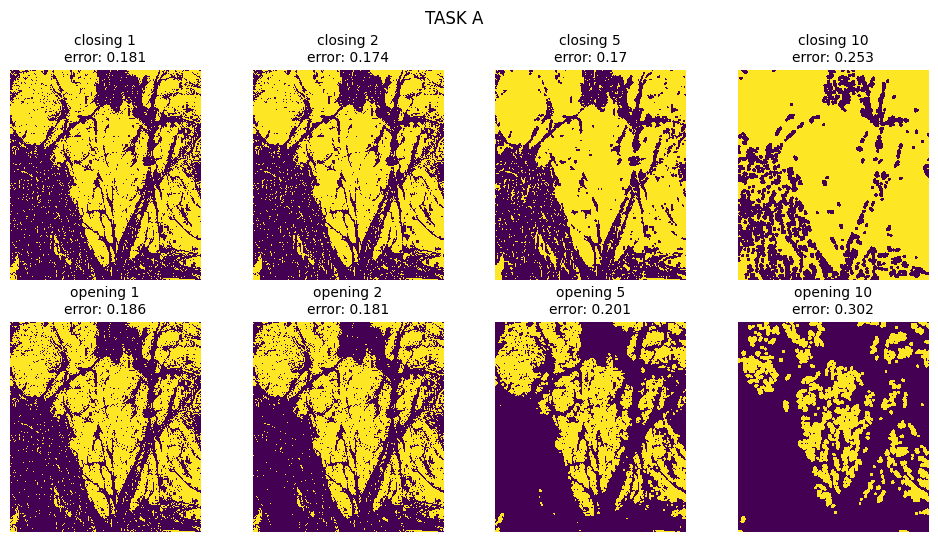

In [37]:
#Task A
fig, ax = plt.subplots(2, 4, figsize=(12,6))
fig.suptitle("TASK A")
for i,n in enumerate([1,2,5,10]):
    disk = skimage.morphology.disk(n)
    closing = skimage.morphology.closing(mask_thresholding, disk)
    opening = skimage.morphology.opening(mask_thresholding, disk)
    ax[0][i].imshow(closing, interpolation="nearest")
    ax[0][i].set_title(f"closing {n}\nerror: {round(error(closing,adeno_gt),3)}", fontsize=10)
    ax[0][i].axis('off')
    ax[1][i].imshow(opening, interpolation="nearest")
    ax[1][i].set_title(f"opening {n}\nerror: {round(error(opening,adeno_gt),3)}", fontsize=10)
    ax[1][i].axis('off')
plt.show()


Closing: 

The goal of applying the closing operation to "mask_thresholding" is to fill the small holes and gaps in the mucinous area and smooth the object boundaries. 

We observed that increasing the disk size improved the effectiveness of the closing operation. First, for a disk size of 1, the difference between the original and the resulting image was minimal (only a 0.1 error difference). However, as we increased the disk size, the holes and gaps within the mucinous area were better filled, and the object boundaries became smoother. A disk size of 5 achieved the best error of 0.17. However, a disk size of 10 led to a loss of fine details in the mucinous area, overly smoothed object boundaries, and enhanced "noise" points in the background. The error for this disk size was significantly higher than that without the closing operation.

Opening: 

The goal of applying the opening operation to "mask_thresholding" is to remove the small holes and gaps in the background. 

Here, for a disk size of 1, a small part of the holes and gaps in the background are removed. For a disk size of 2, we achieve the best error of 0.181. As we increase the size of the disk, the holes and gaps in the background are removed more aggressively, and the error increases. We can see that for a disk size 5, we started removing parts of the mucinous area, and for a disk size of 10, the mucinous area lost its original shape, accompanied with a high error.

Overall, the results emphasize the importance of selecting the right disk size and operation to improve the quality of the resulting mask.



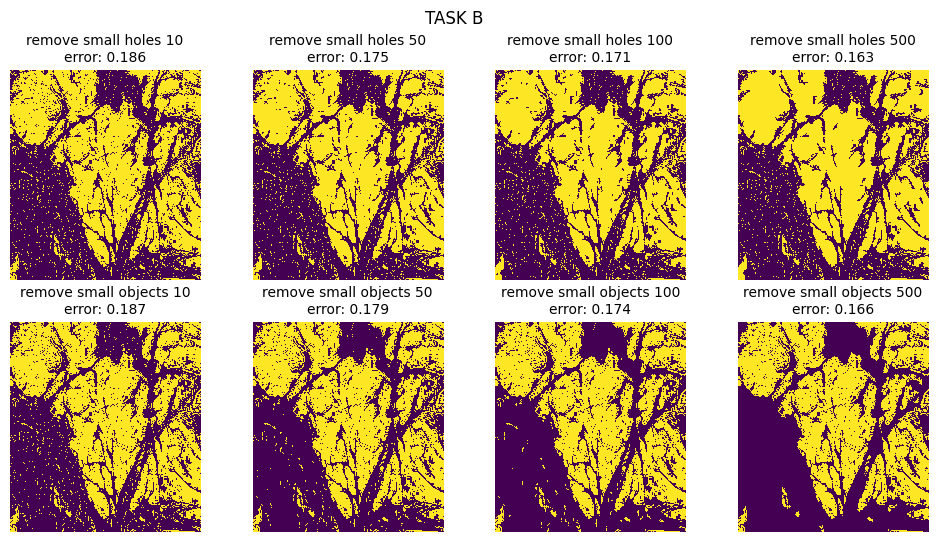

In [38]:
#Task B
fig, ax = plt.subplots(2, 4, figsize=(12,6))
fig.suptitle("TASK B")
for i,n in enumerate([10,50,100,500]):
    disk = skimage.morphology.disk(n)
    holes = skimage.morphology.remove_small_holes(mask_thresholding, n)
    objects = skimage.morphology.remove_small_objects(mask_thresholding, n)
    ax[0][i].imshow(holes, interpolation="nearest")
    ax[0][i].set_title(f"remove small holes {n}\nerror: {round(error(holes,adeno_gt),3)}", fontsize=10)
    ax[0][i].axis('off')
    ax[1][i].imshow(objects, interpolation="nearest")
    ax[1][i].set_title(f"remove small objects {n}\nerror: {round(error(objects,adeno_gt),3)}", fontsize=10)
    ax[1][i].axis('off')
plt.show()

Removing small holes: (from the mucinous area)

First, the hole size 10 being too small, we are not able to fill the holes in the mucinous area, which is illustrated by the low error difference between the original image and the resulted image (=0.05) 
As we increase the size of the holes to remove, we see that the holes in the mucinous area are filled more and more. We achieve the best error (0.163) with a size of 500. 

Removing small objects: (from the background)

If the object size is too small (10 in this case), only a small part of the objects in the background are removed, and the error difference between the original and resulted image is minimal. As we increase the object size to remove, more and more of the background noise is removed, resulting in a better segmentation of the mucinous area. By using an object size of 500, we achieve the best error of 0.166

This shows the importance of choosing the right size when applying morphology operations. If the size of the disk or the object to remove is too small, then the operation will not have a significant impact on the image and the error difference between the original and resulted image will be low. On the other hand, if the size is too large, then the operation may start removing or altering important details in the image and the error difference can increase. 

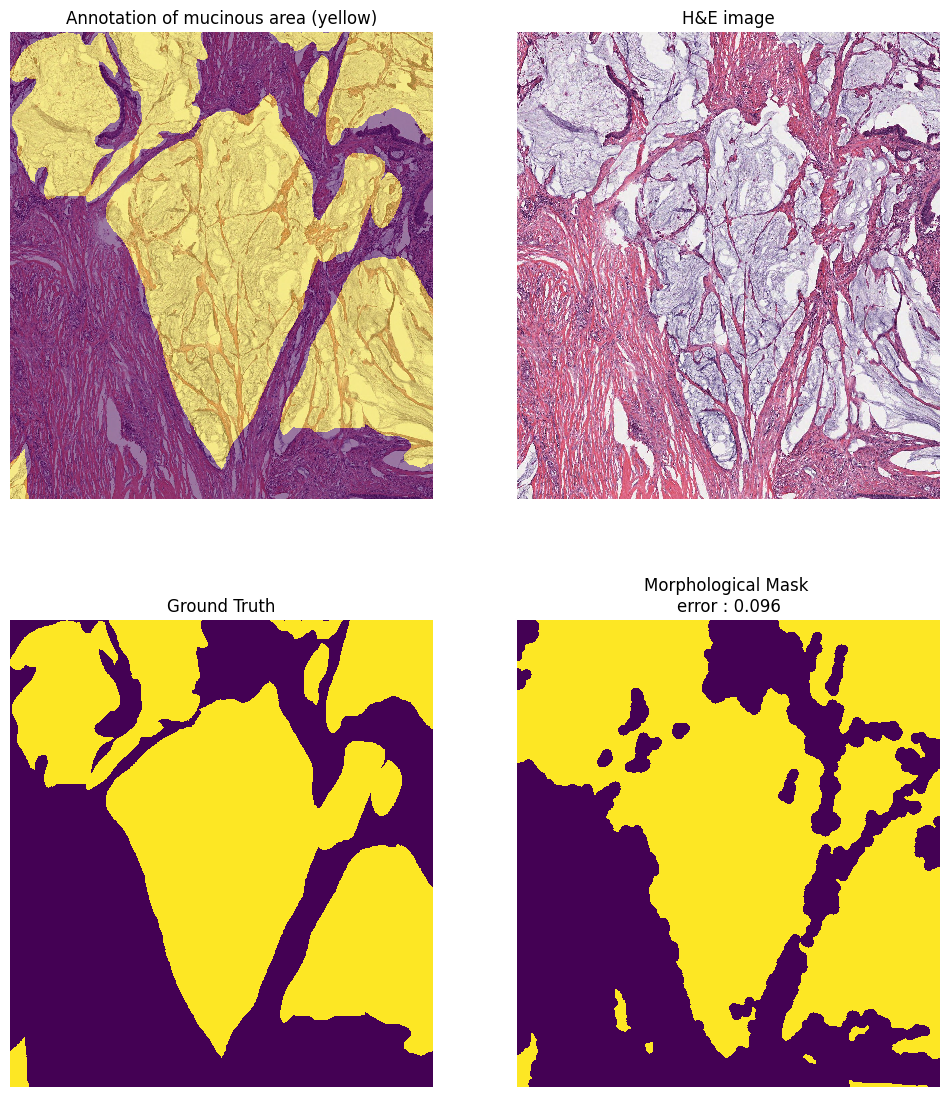

In [39]:
#Task C
mask_morph = np.zeros_like(adeno_gt)
mask_morph = skimage.morphology.remove_small_objects(
    skimage.morphology.remove_small_holes(
        skimage.morphology.closing(
            skimage.morphology.opening(
                skimage.morphology.remove_small_objects(
                    mask_thresholding,
                    600,
                ),
                skimage.morphology.disk(3),
            ),
            skimage.morphology.disk(15),
        ),
        1800,
    ),
    500,
)



# Plot image
fig, ax = plt.subplots(2, 2, figsize=(12, 14))
ax[0][1].imshow(adeno_img, interpolation='nearest')
ax[0][1].set_title('H&E image'.format(im_h, im_w))
ax[0][1].axis('off')

ax[0][0].imshow(adeno_img, interpolation='nearest')
ax[0][0].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[0][0].set_title('Annotation of mucinous area (yellow)')
ax[0][0].axis('off')

ax[1][1].imshow(mask_morph, interpolation='nearest')
ax[1][1].set_title(f"Morphological Mask \nerror : {round(error(mask_morph, adeno_gt),3)}")
ax[1][1].axis('off')

ax[1][0].imshow(adeno_gt, interpolation='nearest')
ax[1][0].set_title("Ground Truth")
ax[1][0].axis('off')

plt.show()

Based on the results of the previous experiments, we can combine the different mophological operations studied to obtain a better mask. 

With the morphological mask implemented, we achieve an error of 0.096. 

---
### 1.4 Region growing (5pts)

In this exercise you will implement from scratch your own region growing algorithm. Choose one of the image channel (R/G/B/H) as the source image. You can use multiple seed point to achieve better results. Plot the best result along with the error rate. Save the mask as the variable `mask_region`.

In [40]:
def region_growing(img, seeds, threshold):
    result = np.zeros(img.shape, dtype=bool)
    result_old = np.zeros(img.shape, dtype=bool)
    for seed in seeds:
        mask = img < threshold
        result[seed] = True
        while np.count_nonzero(result_old != result) > 0:
            result_old = result.copy()
            dilation = skimage.morphology.binary_dilation(result)
            result[mask & dilation] = True
    return result

In [41]:
T = 0.85

hue = skimage.color.rgb2hsv(adeno_img)[:, :, 0]

# Location of the seeds chosen
seeds = [
    (1300, 40),
    (600, 700),
    (250, 250),
    (400, 350),
    (200, 1100),
    (850, 1100),
    (1200, 600),
    (600, 1000),
    (100, 1100),
    (1100, 870),
    (100, 950),
    (200, 400),
]
result = region_growing(hue, seeds, T)

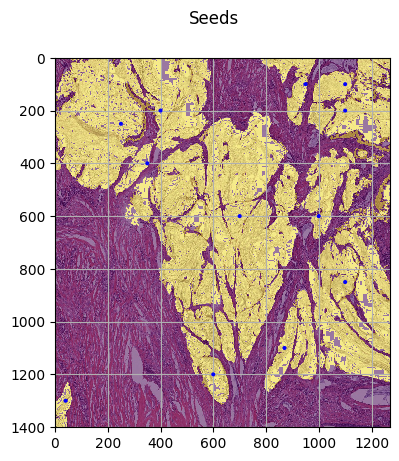

In [42]:
from matplotlib.patches import Circle

patches = [Circle((s[1], s[0]), radius=5, color="blue") for s in seeds]
fig, ax = plt.subplots(1)
fig.suptitle("Seeds")
plt.grid()
ax.set_axisbelow(True)
ax.imshow(adeno_img, interpolation="nearest")
ax.imshow(result, alpha=0.5, interpolation="nearest")

for p in patches:
    ax.add_patch(p)

plt.show(fig)

[]

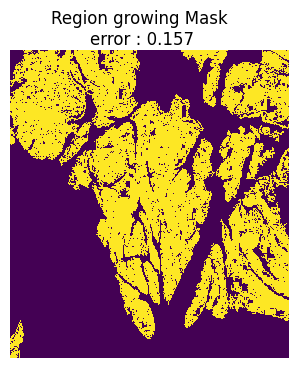

In [43]:
mask_region = np.zeros_like(adeno_gt)
mask_region = result

plt.figure(figsize=(6, 4))
plt.imshow(mask_region, interpolation="nearest")
plt.suptitle(f"Region growing Mask \nerror : {round(error(mask_region, adeno_gt),3)}")
plt.axis("off")
plt.plot()

---
### 1.5 Method comparison (1pt)

In this section we display the overall outputs. Please make sure that you create the variables `mask_thesholding`, `mask_morph`, and `mask_region` to properly display the output. Comment on the results and what you think would be the best approach.

Overall, we can see that each approach has its own advantages and disadvantages. 

Thresholding is a fast and efficient technique that works well when the image is clear and free of noise. However, when there is noise in the image, thresholding can lead to errors and inaccuracies.

The morphology approach is a refinement of the thresholding approach and can improve the accuracy of the segmentation by smoothing the object boundaries and filling the holes and gaps.

Region growing is a more precise technique that is better suited for extracting features from images with clear and distinct boundaries. However, it is computationally intensive and can be slow to apply, particularly when dealing with large or complex images. Additionally, region growing may not work well for images with cells that have small or irregular shapes, or cells with filaments connecting them.

In general, there is a trade-off between computation and precision. If the image has simple structures and a clear boundary between the object of interest and the background, the thresholding approach may be sufficient. If the image has more complex structures or variations in intensity, the morphology or region growing approaches may be necessary. The best approach depends on the specific requirements of the application and the resources available.

Based on our results, for our specific case, a combination of the morphology and thresholding approaches seems to give the best performance. However, there is still room for improvement, and it may be worth exploring other approaches or combining different techniques like first region growing and then morphological operations.

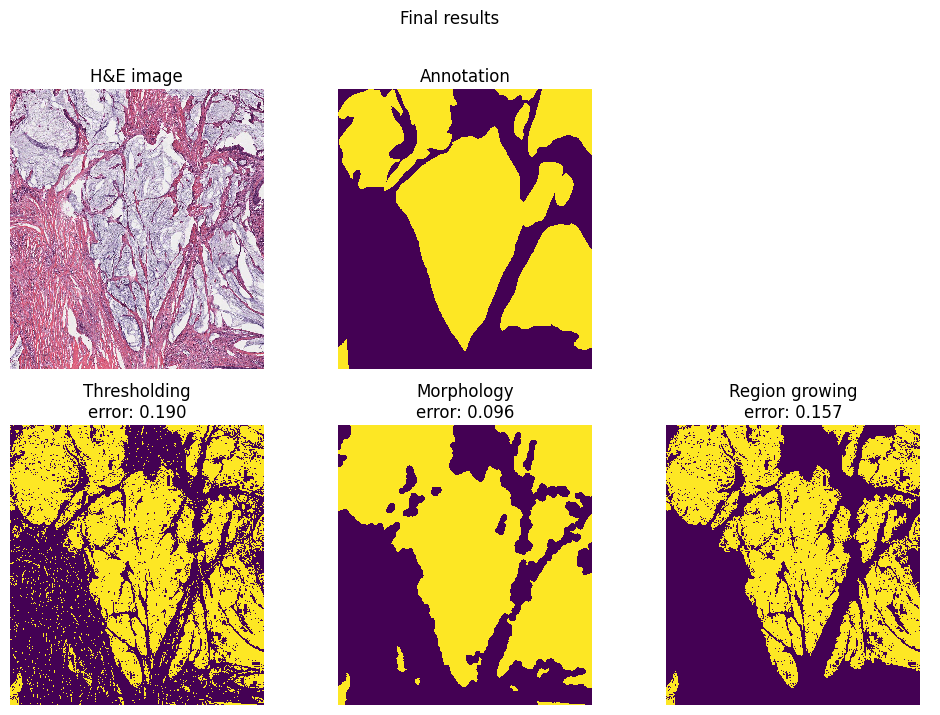

In [44]:
error_th = 1 - (mask_thresholding == adeno_gt).mean()
error_morph = 1 - (mask_morph == adeno_gt).mean()
error_region = 1 - (mask_region == adeno_gt).mean()


# Display MRI image
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

# Plot image
ax[0, 0].imshow(adeno_img, interpolation="nearest")
ax[0, 0].set_title("H&E image".format(im_h, im_w))

# Plot image with overlay
ax[0, 1].imshow(adeno_gt, interpolation="nearest")
ax[0, 1].set_title("Annotation")

# Plot estimation using thresholding
ax[1, 0].imshow(mask_thresholding, interpolation="nearest")
ax[1, 0].set_title("Thresholding\nerror: {:.3f}".format(error_th))

# Plot estimation using Contour detection
ax[1, 1].imshow(mask_morph, interpolation="nearest")
ax[1, 1].set_title("Morphology\nerror: {:.3f}".format(error_morph))


# Plot estimation using Region growing
ax[1, 2].imshow(mask_region, interpolation="nearest")
ax[1, 2].set_title("Region growing\nerror: {:.3f}".format(error_region))


[a.axis("off") for a in ax.ravel()]


plt.suptitle("Final results")
plt.show()

---
## Part 2: Axon segmentations (10 points)

#### Intro 

Axon segmentation is vital to neuroscience research as it enables the study of neurons' morphology and connectivity. We will conduct two exercises to evaluate the impact of your segmentation algorithms under different independent artefacts. Each exercise consists of a synthetic **Ground Truth (GT)** and two more images simulating a specific artifact.

The **Ground Truth**  has tree main compartments. 1) The inner part of the axon. 2) The outer layer of the axon (called myelin) and the extracellular slace (the background of the image). 

The task consists into segmenting the three main compartments in the image to compute the inner-axon and outer-axon radii distribution.


To compute the radii, we suggest the following approximation.
$$\hat{r}_{I}= \sqrt{\frac{A_{yellow}}{\pi}}$$
$$\hat{r}_{O}= \sqrt{\frac{A_{yellow} + A_{blue}}{\pi}}$$
Where **A** is the corresponding area of the comparments. 
**Using this image as reference** 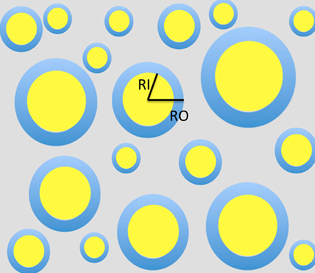

#### Artifacts simulated:

Excercise 1) Two images with different levels of SNR (signal to noise ratio). The images have rician noise.
Exercise  2) Two images adquired using a fraction of the fourier space. Only Lowest frequency are used to reconstruct the image. (simulating fast aquisitions in MRI)

Ensure your algorithm works on the GT before you go to the test cases with artifacts. Apply any preprocessing needed to the image. The preprocessing can be different for each type of image.

### Tasks

For each exercise we ask to:

1) Segment the images with the following colors: blue the inner part of the axon, red the outer part of the axon (myelin) and white for the backround(example) 

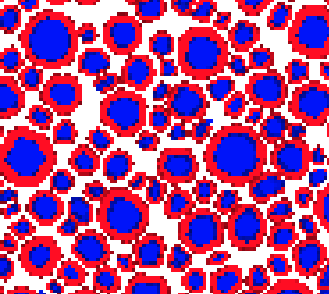

2) Count the number of axons obtained in the sample, calculate the radii for each axons, and display a radii histogram for the each of the images(GT and test cases).

In the exercises, assume that each pixel side is $(0.1 \mu m)$, i.e. a pixel has an area of $(0.01 \mu m^2 )$

## Grading 
The answers does not have to be perfect, they just be a good approximation.

1. Developing an algorithm that works for the two GT images. **(3 points)** 
2. Use preprosesing to prepare the images with SNR and the Low frequencies.  (**1 point** for SNR preprocesing , **1 point** for Low-frequency images preprocesing)
3. Running the algorithm in the test images. **1/2 point** SNR, **1/2 point** Low freqs
4. Computing and plotting radii distributions **(1 point)**
5. Explaining and discussing your implementation. **(3 points )**
    Try to be specific, not necessarily long. In the discussion include:
 1. What worked? 
 2. What did not work?
 3. Why do you think it does not work? 
 4. How could you improve your algorithms as future work?  Try to avoid general comments like "using deep learning" 
 
**Extra points: Real data example (3 points), the algorithm should display a _good enough_ segmentation.**

In [15]:
import cv2
import matplotlib.pyplot as plt
from skimage.segmentation import flood_fill
import numpy as np

data_base_path = os.path.join(os.pardir, "data")
print(data_base_path)
data_folder = "lab-01-data"

path_folder = os.path.join(data_base_path, data_folder) + "/"


..\data


### 2.1 SNR

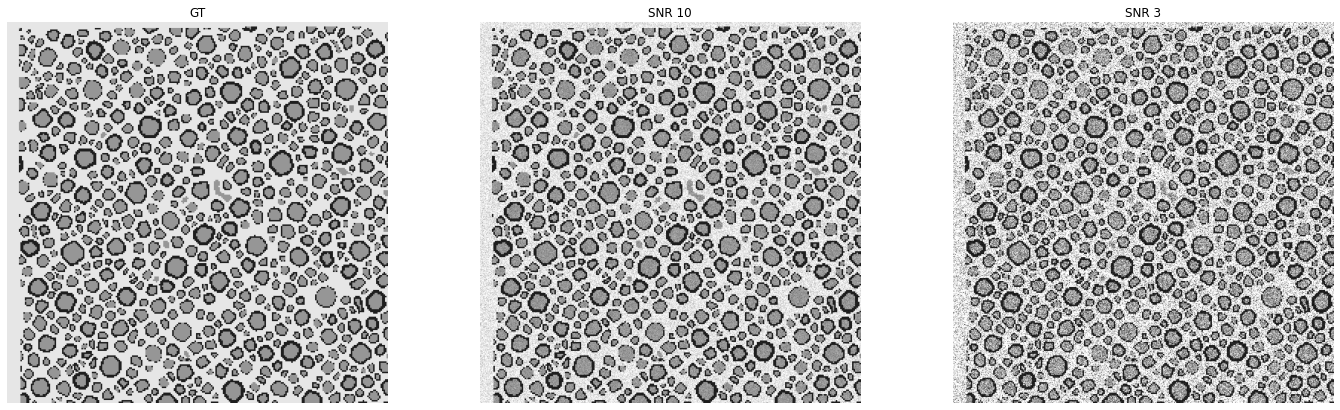

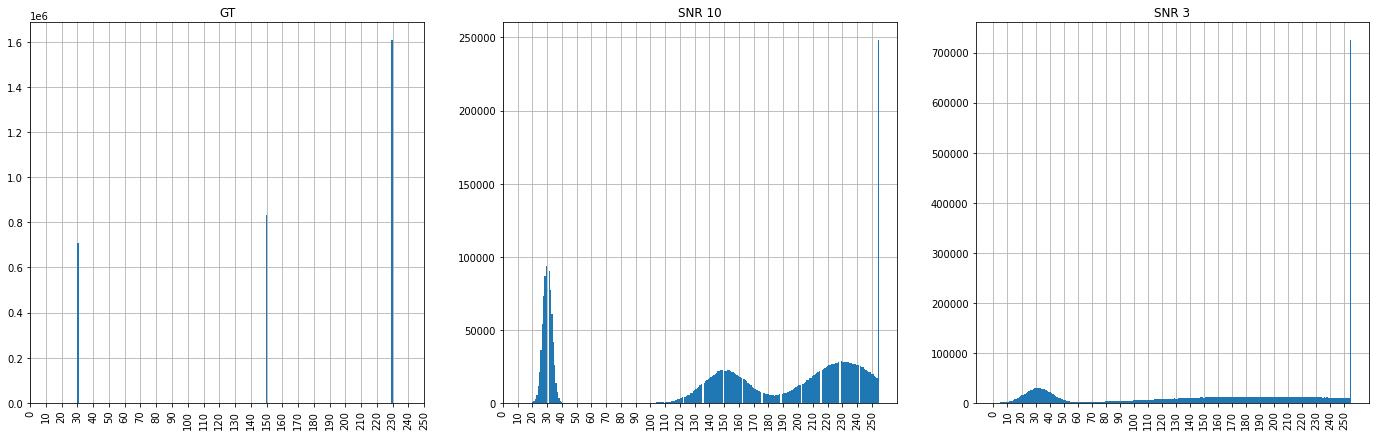

In [16]:
files = ["GT_0.png", "test_0_0.png", "test_0_1.png"]
gt_0 = cv2.imread(path_folder + files[0])
snr_10 = cv2.imread(path_folder + files[1])
snr_3 = cv2.imread(path_folder + files[2])

images = [gt_0, snr_10, snr_3]
im_names = ["GT", "SNR 10", "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig_hist, axes_hist = plt.subplots(1, 3, figsize=(24, 7))
for ax, ax_hist, im, nm in zip(axes.ravel(), axes_hist.ravel(), images, im_names):
    ax.imshow(im[0:512, 0:512])
    ax.axis("off")
    ax.set_title(nm)

    ax_hist.hist(im.ravel(), 256)
    ax_hist.set_title(nm)
    ax_hist.set_xticks(np.arange(0, 255, 10), labels=np.arange(0, 255, 10), rotation=90)
    ax_hist.grid()
    ax_hist.set_axisbelow(True)
plt.show()
plt.show()

### 2.1.1 Preprocessing 


To preprocess a picture with Rician noise, a low pass filter is needed. The added noise is typically high frequency, as you can observe in the images. However, it's crucial to be careful when using a low pass filter during this preprocessing, as it may smooth the edges and even delete small axons.

We initially tried classical low pass filters such as Gaussian and Butterworth, as well as a median filter. However, we encountered the exact issues mentioned above. Consequently, we attempted some more sophisticated filters proposed by __[skimage](https://scikit-image.org/docs/stable/api/skimage.restoration.html#skimage.restoration.denoise_tv_bregman)__. The Bregman method proved to be highly effective for our application.

This filter strikes a balance between smoothing (total variation) and not distorting the image too much. 
Given 
$f$, a noisy image (input data), total variation denoising (also known as total variation regularization) aims to find an image $u$ with less total variation than 
$f$, under the constraint that 
$u$ remain similar to $f$. Essentially, it solves an optimization problem similar to training an NN with regularization on the gradient.

$$\min_{u} \sum_{i=0}^{N-1} \left( \left| \nabla{u_i} \right| + \frac{\lambda}{2}(f_i - u_i)^2 \right)$$

$\lambda$ is a hyperparameter that needs to be tuned. As $\lambda \to 0$, the total variation term dominates, forcing the solution to have smaller total variation, at the expense of looking less like the input data.

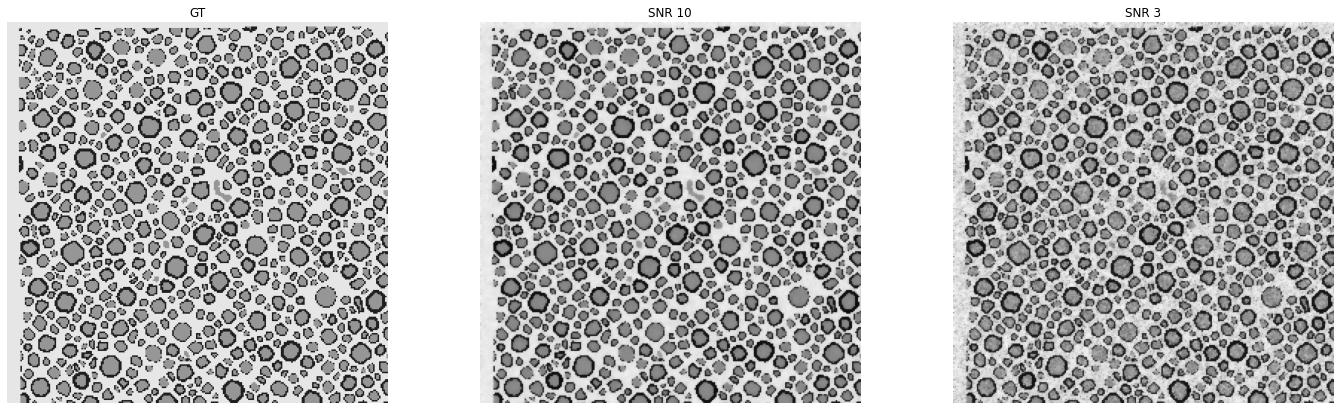

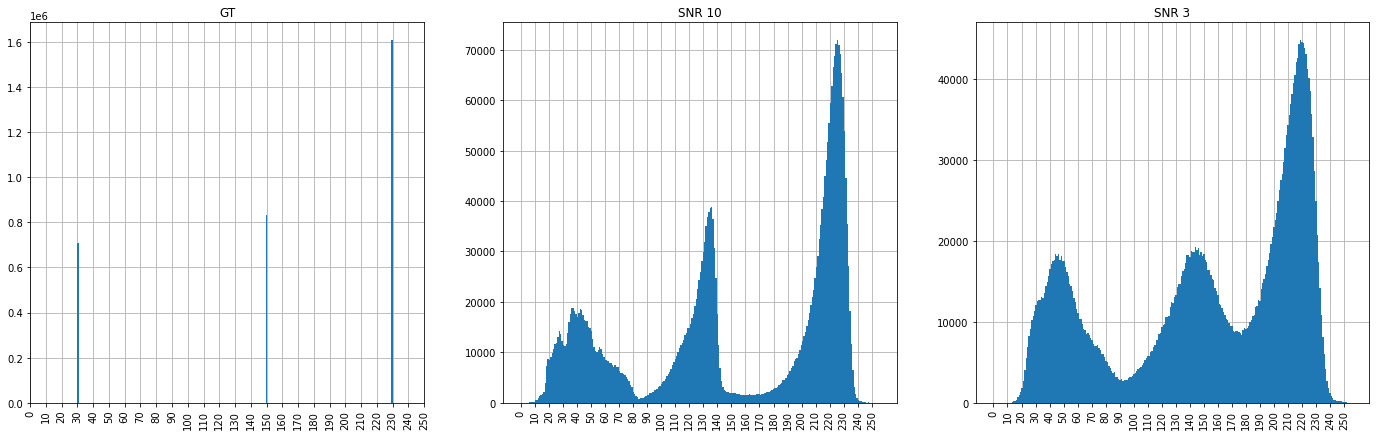

In [17]:
def preprocessing_snr(img):
    img_filter = skimage.restoration.denoise_tv_bregman(img, weight=5)
    max = np.max(img_filter)
    min = np.min(img_filter)
    normalized = (img_filter - min) / (max - min)
    return np.uint8(np.round(255 * normalized))


snr_10_pre = preprocessing_snr(snr_10)
snr_3_pre = preprocessing_snr(snr_3)

images = [gt_0, snr_10_pre, snr_3_pre]
im_names = ["GT", "SNR 10", "SNR 3"]
fig_pre, axes_pre = plt.subplots(1, 3, figsize=(24, 7))
fig_hist, axes_hist = plt.subplots(1, 3, figsize=(24, 7))
for ax_pre, ax_hist, im, nm in zip(
    axes_pre.ravel(), axes_hist.ravel(), images, im_names
):
    ax_pre.imshow(im[0:512, 0:512])
    ax_pre.axis("off")
    ax_pre.set_title(nm)

    ax_hist.hist(im.ravel(), 256)
    ax_hist.set_title(nm)
    ax_hist.set_xticks(np.arange(0, 255, 10), labels=np.arange(0, 255, 10), rotation=90)
    ax_hist.grid()
    ax_hist.set_axisbelow(True)
plt.show()

In [18]:
def threshold(img, t1, t2):
    result = np.zeros_like(img[:, :, 0])
    mask1 = img[:, :, 0] > t1
    mask2 = img[:, :, 0] > t2
    result[mask1] = 255 // 2
    result[mask2] = 255
    return result

gt_0_th = threshold(gt_0, 100, 200)
snr_10_th = threshold(snr_10_pre, 82, 165)
snr_3_th = threshold(snr_3_pre, 92, 180)

To address the salt and pepper noise that was still present in the image with more noise (SNR 3) after thresholding, we needed to perform additional preprocessing. We found that a simple median filter was highly effective in reducing this noise.

Following this step, we closed the remaining white holes present in the inner part of the axons to further improve the image.

In [19]:
snr_3_th_post = cv2.medianBlur(snr_3_th, 3)
snr_3_th_post = skimage.morphology.area_opening(snr_3_th_post, 11)


### 2.1.2 Results Segmetations

In [20]:
def RGB_image(gray_img):
    color_img = np.stack(
        (
            255 * np.ones_like(gray_img),
            np.zeros_like(gray_img),
            np.zeros_like(gray_img),
        ),
        axis=-1,
    )  # outer layer of the axon (red)
    color_img[gray_img == 255 // 2, :] = [0, 0, 255]  # inner layer of the axon (blue)
    color_img[gray_img == 255, :] = [255, 255, 255]  # background (white)
    return color_img

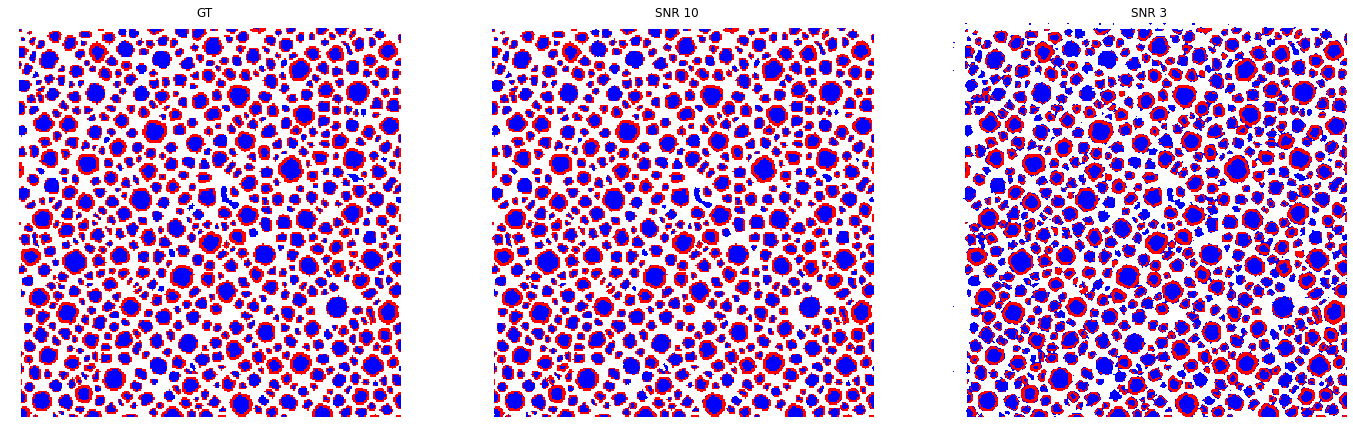

In [21]:
images = [gt_0_th, snr_10_th, snr_3_th_post]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(RGB_image(im[0:512, 0:512]), interpolation="nearest")
    ax.axis("off")
    ax.set_title(nm)
plt.show()

In [132]:
def calculate_radii_distribution(img, T1, T2, remove_objects, value1=10, value2=6):
    img_bool_i= np.zeros_like(img[:,:,0], dtype=bool)
    img_bool_o= np.zeros_like(img[:,:,0], dtype=bool)
    
    mask1 = img[:,:,0]>T1
    mask2 = img[:,:,0]<T2
    img_bool_i[mask1&mask2]=True
    img_bool_o[mask2]=True

    if remove_objects==True:
        #img_bool_i= skimage.morphology.remove_small_objects(img_bool_i, 8)
        #img_bool_o= skimage.morphology.remove_small_objects(img_bool_o, 10)
        img_bool_o= skimage.morphology.area_opening(img_bool_o, value2)
        img_bool_i= skimage.morphology.area_opening(img_bool_i, value1)
        
    labels_i = skimage.measure.label(img_bool_i)
    labels_o = skimage.measure.label(img_bool_o)

    area_um_i=[]
    area_um_o=[]

    for i in range(1,np.max(labels_i)+1):
        area_um_i.append(np.count_nonzero(labels_i==i)*0.01)
    for j in range(1,np.max(labels_o)+1):
        area_um_o.append(np.count_nonzero(labels_o==j)*0.01)
    
    r_i = np.sqrt(np.array(area_um_i)/np.pi)
    r_o = np.sqrt(np.array(area_um_o)/np.pi)
    
    return r_i, r_o

In [133]:
r_i_gt, r_o_gt= calculate_radii_distribution(gt_0, 100, 200, False)

In [134]:
r_i_snr10, r_o_snr10= calculate_radii_distribution(snr_10_pre,86,147,True)


In [135]:
r_i_snr3, r_o_snr3= calculate_radii_distribution(snr_3_pre,93,173,True)

### 2.1.3 Radii histrograms 

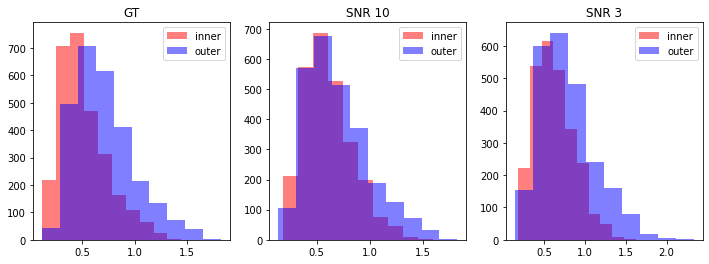

In [136]:
## results Radii distribution. proposal feel free to change it
import numpy as np

rads_gt = [ r_i_gt ,r_o_gt]
rads_snr10 = [ r_i_snr10 ,r_o_snr10]  # your result
rads_snr3 = [ r_i_snr3 ,r_o_snr3]  # your result

all_rads= [rads_gt , rads_snr10 , rads_snr3] 

images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, rads, nm in zip(axes.ravel(), all_rads, im_names):
    ax.hist(rads[0]  , color = "red" , label = "inner" ,alpha= 0.5)
    ax.hist(rads[1]  , color = "blue" , label = "outer" ,alpha= 0.5)
    ax.legend()
    ax.set_title(nm)
plt.show()

### 2.2 Low frequencies

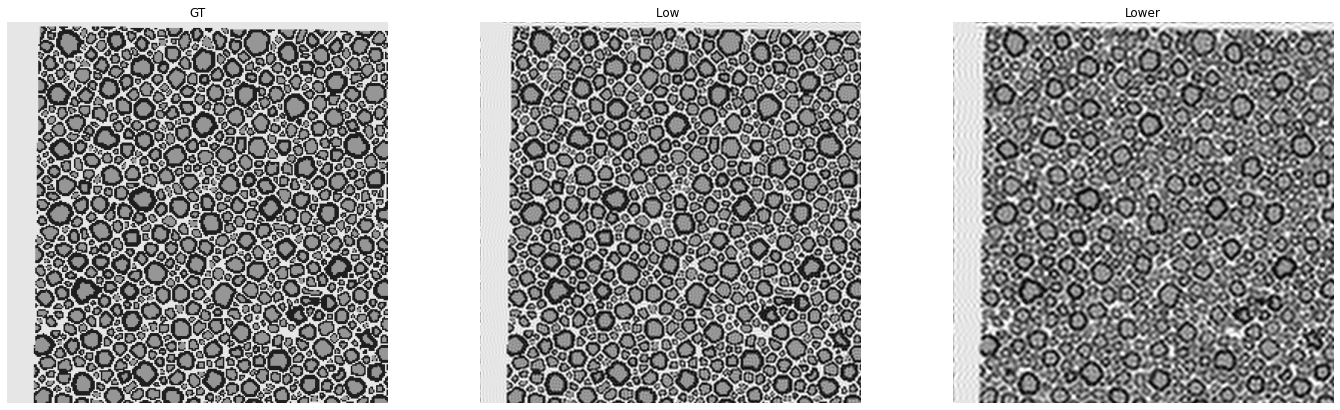

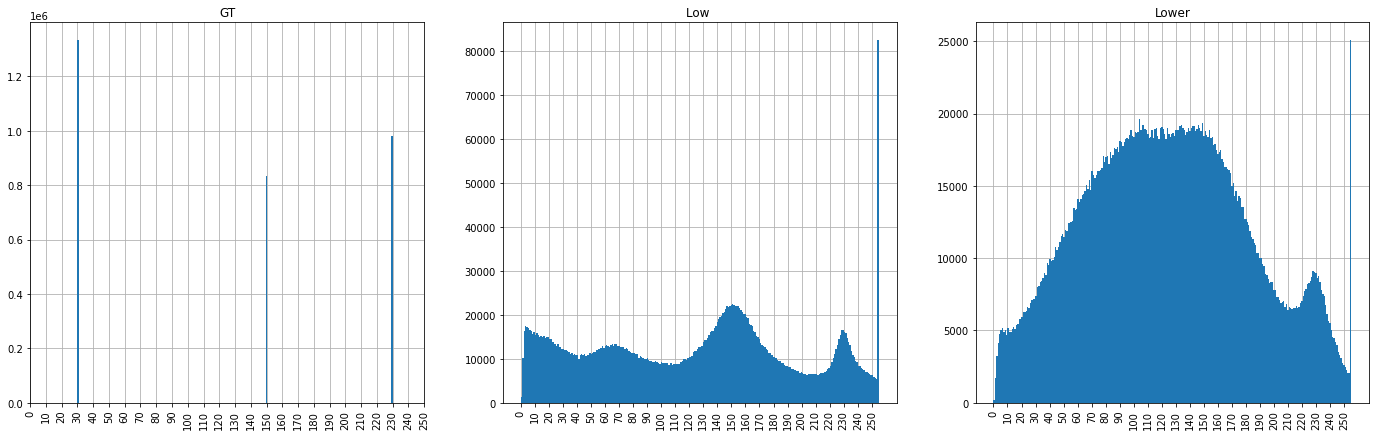

In [84]:
files = ["GT_3.png", "test_3_0.png", "test_3_1.png"]
path = "data/"
gt_3 = cv2.imread(path_folder + files[0])
lowfreq0 = cv2.imread(path_folder + files[1])
lowfreq1 = cv2.imread(path_folder + files[2])

images = [gt_3, lowfreq0, lowfreq1]
im_names = ["GT", "Low ", "Lower"]
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig_hist, axes_hist = plt.subplots(1, 3, figsize=(24, 7))
for ax, ax_hist, im, nm in zip(axes.ravel(), axes_hist.ravel(), images, im_names):
    ax.imshow(im[0:512, 0:512])
    ax.axis("off")
    ax.set_title(nm)

    ax_hist.hist(im.ravel(), 256)
    ax_hist.set_title(nm)
    ax_hist.set_xticks(np.arange(0, 255, 10), labels=np.arange(0, 255, 10), rotation=90)
    ax_hist.grid()
    ax_hist.set_axisbelow(True)
plt.show()

### 2.2.1 Preprocessing

This task is much harder than the first one because when we take only a part of the Fourier transform to reconstruct the image, we lose high-frequency content. In contrast, with Rician noise, the content was still present but hidden by the noise.

The Gibbs phenomenon, which is particularly noticeable in the lowfreq1 image, is due to the multiplication of a quasi-rect function in the frequency domain. To retrieve the high-frequency content, we need to apply a high-pass filter, but we also need to keep the low-frequency content because we are not only interested in detecting the edges.

Therefore, the optimal approach is to use the unsharp mask technique proposed by skimage. This method involves first blurring the image with a Gaussian filter, where the standard deviation $\sigma$ is set to the radius of the filter. The blurred image is then subtracted from the original image, and the result is multiplied by a scaling factor (amount) and added back to the original image:

$$enhanced\ image = original + amount \cdot (original - blurred)$$

The result of the subtraction operation $(original-blurred)$ acts as a Gaussian high-pass filter, which enhances the high-frequency components of the image. Since the Bregman method was successful in part 2.1, we combined this filtering step with it to further improve the reconstruction quality.

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\filters\_unsharp_mask.py:11: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.21. Set `channel_axis=-1` explicitly to silence this warning.
  blurred = gaussian(image, sigma=radius, mode='reflect')


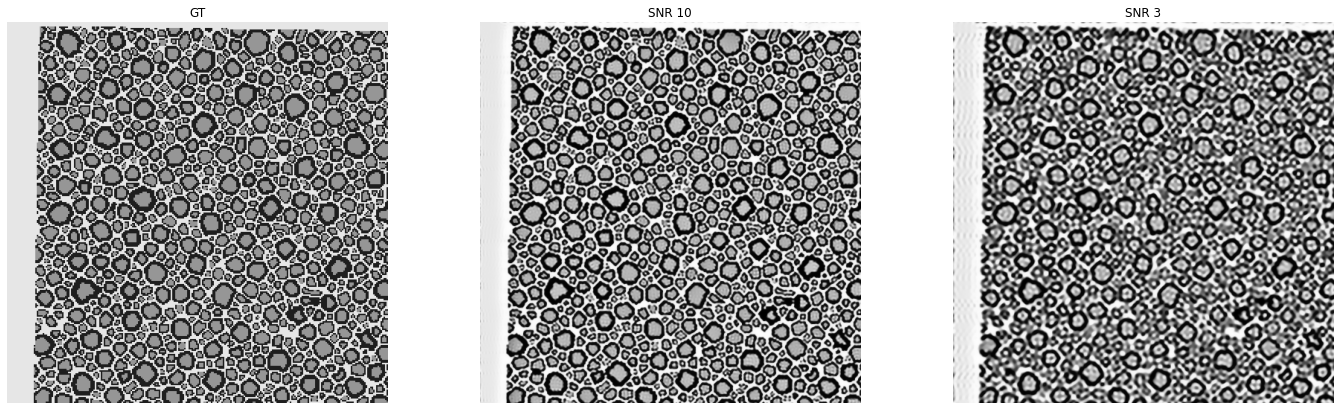

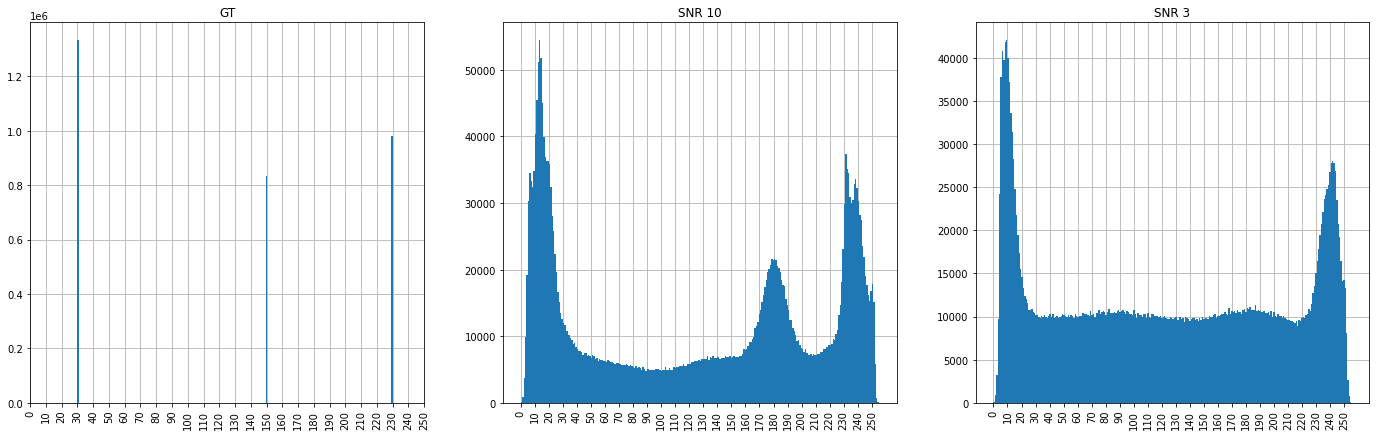

In [100]:
def preprocessing_lowfreq(img):
    img_filter = skimage.filters.unsharp_mask(img, radius=10, amount=1)
    img_filter = skimage.restoration.denoise_tv_bregman(img_filter, weight=10)
    max = np.max(img_filter)
    min = np.min(img_filter)
    normalized = (img_filter - min) / (max - min)
    return np.uint8(np.round(255 * normalized))


lowfreq0_pre = preprocessing_lowfreq(lowfreq0)
lowfreq1_pre = preprocessing_lowfreq(lowfreq1)

images = [gt_3, lowfreq0_pre, lowfreq1_pre]
fig_pre, axes_pre = plt.subplots(1, 3, figsize=(24, 7))
fig_hist, axes_hist = plt.subplots(1, 3, figsize=(24, 7))
for ax_pre, ax_hist, im, nm in zip(
    axes_pre.ravel(), axes_hist.ravel(), images, im_names
):
    ax_pre.imshow(im[0:512, 0:512])
    ax_pre.axis("off")
    ax_pre.set_title(nm)

    ax_hist.hist(im.ravel(), 256)
    ax_hist.set_title(nm)
    ax_hist.set_xticks(np.arange(0, 255, 10),
                       labels=np.arange(0, 255, 10), rotation=90)
    ax_hist.grid()
    ax_hist.set_axisbelow(True)
plt.show()


In [57]:
gt_3_th = threshold(gt_3, 100, 200)
lowfreq0_th = threshold(lowfreq0_pre, 95, 205)
lowfreq1_th = threshold(lowfreq1_pre, 70, 170)

Post-processing is still necessary to close any remaining white holes. However, in this step, median blur is not required.

In [58]:
lowfreq0_th_post = skimage.morphology.area_opening(lowfreq0_th, 15)
lowfreq1_th_post = skimage.morphology.area_opening(lowfreq1_th, 50)

### 2.2.2 Results Segmetations

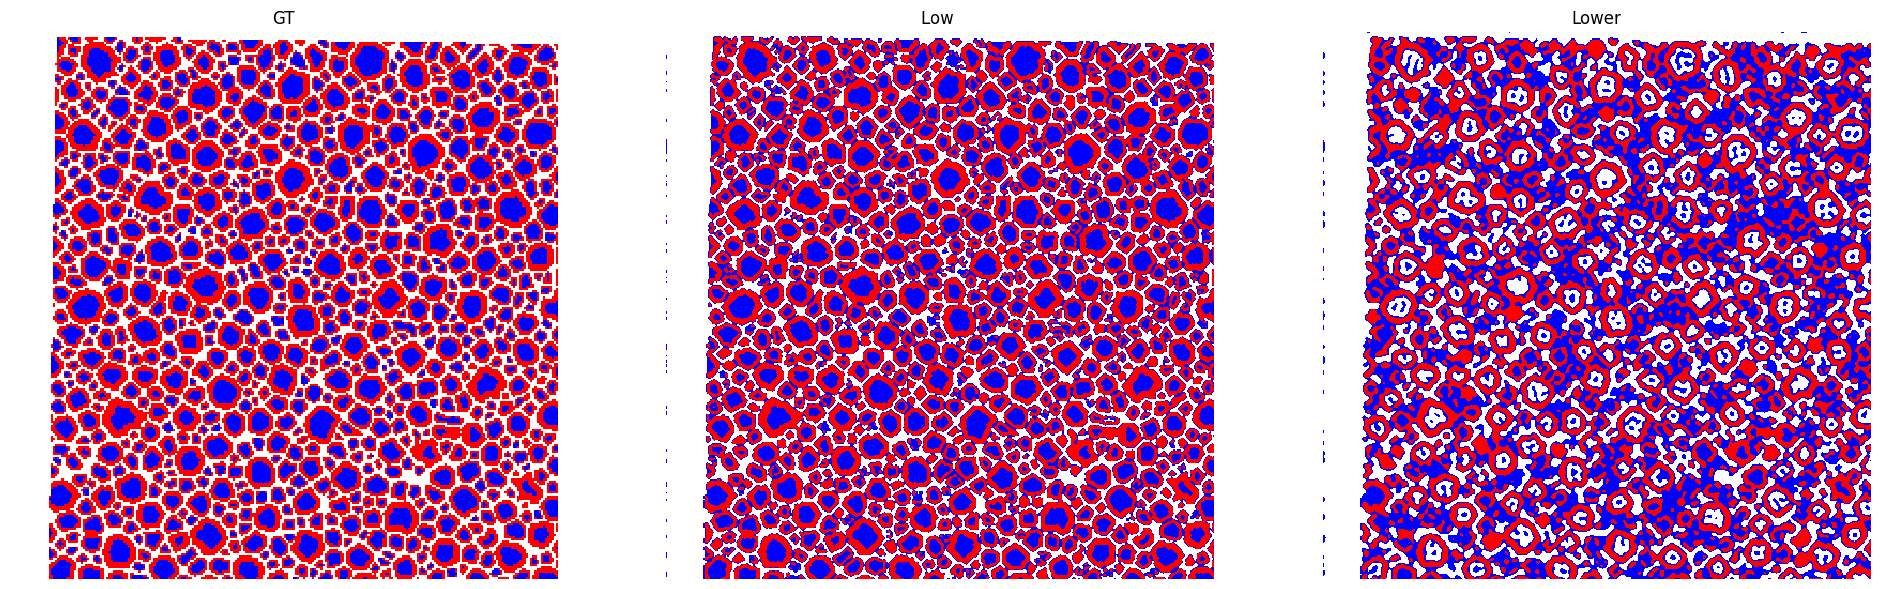

In [59]:
images = [gt_3_th, lowfreq0_th_post, lowfreq1_th_post]
im_names = ["GT", "Low ", "Lower"]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(RGB_image(im[0:512, 0:512]), interpolation="nearest")
    ax.axis("off")
    ax.set_title(nm)
plt.show()

While the results obtained for the `lowfreq1` are not yet suitable for our applications, they are already a significant improvement when compared to the initial histograms.

However, for this particular task, we believe that a different approach to image segmentation should be employed. Although preprocessing did aid in the segmentation process, relying solely on thresholding may have been the root cause of the poor results. We suggest using a more sophisticated algorithm for segmentation, such as the watershed method.



### 2.2.3 Radii histrograms


In [106]:
r_i_gt_3, r_o_gt_3 = calculate_radii_distribution(gt_3, 100, 200, False)

In [137]:
r_i_low, r_o_low= calculate_radii_distribution(lowfreq0_pre, 95,205,True, 50, 50)

In [138]:
r_i_lower, r_o_lower= calculate_radii_distribution(lowfreq1_pre, 70,270,True, 50, 50)

The same method `radii` was used. 

Because the sticked axons are taken as one, some big clusters of axons were considered as one, with a radius of ~30. As this is aberrant, one can look remove for example the 10 biggest radii (over hundreds of radii).

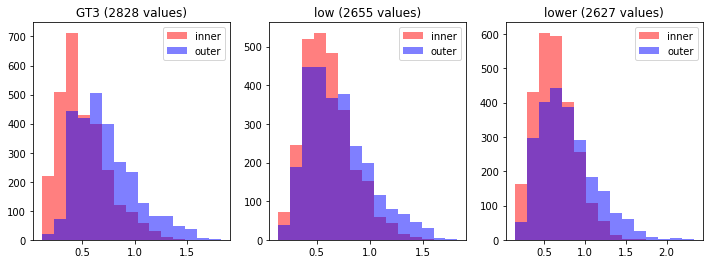

In [139]:
rads_outer = np.random.normal(0, 1, 200)
rads_inner = np.random.normal(0, 1, 200)

rads_gt_3 = [r_i_gt_3, r_o_gt_3]
rads_low = [r_i_low, r_o_low]
rads_lower = [r_i_lower, r_o_lower]

bins=15

images = [gt_3 , lowfreq0, lowfreq1]
im_names = ["GT3", "low", "lower"]

all_rads= [rads_gt, rads_snr10, rads_snr3] 

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, rads, nm in zip(axes.ravel(), all_rads, im_names):
    range_ = [np.min([np.min(rads[0]), np.min(rads[1])]),
               np.max([np.max(rads[0]), np.max(rads[1])])] # In order to make the two hists having the same range
    ax.hist(rads[0], bins=15, color = "red" , label = "inner" ,alpha= 0.5, range=range_)
    ax.hist(rads[1], bins=15, color = "blue" , label = "outer" ,alpha= 0.5, range=range_)
    ax.legend()
    ax.set_title(nm + " (" + str(len(rads[0])) + ' values)')
plt.show()


### 2.5 Not mandatory exercise, Real data ( 3 points )

The points are given just by having a good enough segmentation.

In [62]:
def RGB_image_real(gray_img):
    color_img = np.stack(
        (
            255 * np.ones_like(gray_img),
            np.zeros_like(gray_img),
            np.zeros_like(gray_img),
        ),
        axis=-1,
    )  # outer layer of the axon (red)
    color_img[gray_img == 255 // 2, :] = [255, 255, 255] # background (white)
    color_img[gray_img == 255, :] = [0, 0, 255]   # inner layer of the axon (blue) 
    return color_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


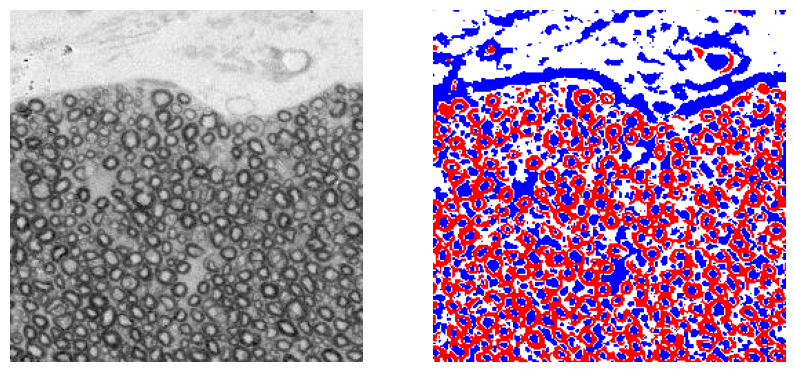

In [67]:
# Add your implementation and discussion
import cv2

files = ["extra_point.png"]
real_data = cv2.imread(path_folder + files[0])
real_data_pre = skimage.restoration.denoise_tv_bregman(real_data , weight=10)
real_data_pre  = skimage.filters.unsharp_mask(real_data_pre, radius=4, amount=10)
real_data_th = threshold(real_data_pre, 0.01, 0.99)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
ax1.imshow(real_data[:256, :256])
ax1.axis("off")
ax2.imshow(RGB_image_real(real_data_th[:256, :256]))
ax2.axis("off")
plt.show()